In [1]:
suppressMessages(library(survminer))
suppressMessages(library(survival))
suppressMessages(library(forestplot))
suppressMessages(library(ggsci))
suppressMessages(library(dplyr))
suppressMessages(library(adjustedCurves))
suppressMessages(library(tidyverse))
suppressMessages(library(cmprsk))
suppressMessages(library(caret))
library(tidyr)

source("funcs/rfuncs.R")

## 1. Load Dataset
---

In [2]:
data.df <- read.table("data/processed/AL_with_ccp_03.tsv", sep="\t", header=T, row.names='Code.ID')

# Rename columns
column_mapping <- c("LC.Isotype"="Kappa_or_lambda_PCD", 
                    "BU.Cardiac.Stage"="BU__BNP_based__cardiac_staging",
                    "BMPC.%"="Bone_marrow_plasma_cells____"
                   )

data.df <- data.df %>% rename(!!!column_mapping)

# Filter for time from admission >=0
data.df <- data.df[data.df$time_from_admission>=0,]

# Collapse Race
data.df <- data.df %>%
   mutate(Race = ifelse(Race %in% c('American_Indian_Alaska_Native','Multiracial','Native_Hawaiian_Pacific', 'Unknown/other'), 'Other', Race))

# Fix NULL values
data.df <- data.df %>% mutate(BU.Cardiac.Stage = ifelse(BU.Cardiac.Stage=="", NA, BU.Cardiac.Stage))
data.df <- data.df %>% mutate(Primary_organ = ifelse(Primary_organ=="", NA, Primary_organ))
data.df <- data.df %>% mutate(LC.Isotype = ifelse(LC.Isotype=="", NA, LC.Isotype))

# assign cluster to var
data.df$m02q3_cluster_n <- factor(data.df$m02q3_cluster_n, levels=c("Low","Intermediate","High"))
data.df <- data.df[complete.cases(data.df[,"m02q3_cluster_n"]),]
data.df$m02q4_cluster_n <- factor(data.df$m02q4_cluster_n, levels=c("Low","Intermediate-Low","Intermediate","High"))
data.df$fna3_cluster_n <- factor(data.df$fna3_cluster_n, levels=c("Low","Intermediate","High"))
data.df$BU.Cardiac.Stage <- as.factor(data.df$BU.Cardiac.Stage)

# As Factor
data.df$LC.Isotype <- as.factor(data.df$LC.Isotype)
data.df$Sex <- as.factor(data.df$Sex)
data.df$Race <- as.factor(data.df$Race)
data.df$Era <- as.factor(data.df$Era)

In [3]:
# Load Relapsed Data
relapse.df <- read.table("data/processed/relapse_processed.tsv", sep="\t", header=T, row.names="X")
relapse.df <- cbind(data.df[row.names(relapse.df),],relapse.df)

# Load processed treatment data
tx.df <- read.table("data/processed/AL_with_ccp_tx_04.tsv", sep="\t", header=T, row.names="Code.ID")
tx.df <- cbind(data.df[row.names(tx.df),],tx.df[,c("tx_within_6mo","response_in_6mo","response_in_12mo","time_to_response",
    "status_response", "PI_tx", "Mel_tx", "Dara_tx", "IMiD_tx","transplant_within_6mo", "transplant_within_12mo",
    "time_to_relapse","status_relapse")])

# As Factor
tx.df$tx_within_6mo <- as.factor(tx.df$tx_within_6mo)
tx.df$response_in_12mo <- as.integer(as.logical(tx.df$response_in_12mo))
tx.df$response_in_6mo <- as.integer(as.logical(tx.df$response_in_6mo))
tx.df$PI_tx <- as.integer(as.logical(tx.df$PI_tx))
tx.df$Mel_tx <- as.integer(as.logical(tx.df$Mel_tx))
tx.df$Dara_tx <- as.integer(as.logical(tx.df$Dara_tx))
tx.df$IMiD_tx <- as.integer(as.logical(tx.df$IMiD_tx))

tx.df$transplant_within_6mo <- as.integer(as.logical(tx.df$transplant_within_6mo))
tx.df$transplant_within_12mo <- as.integer(as.logical(tx.df$transplant_within_12mo))

null device 
          1

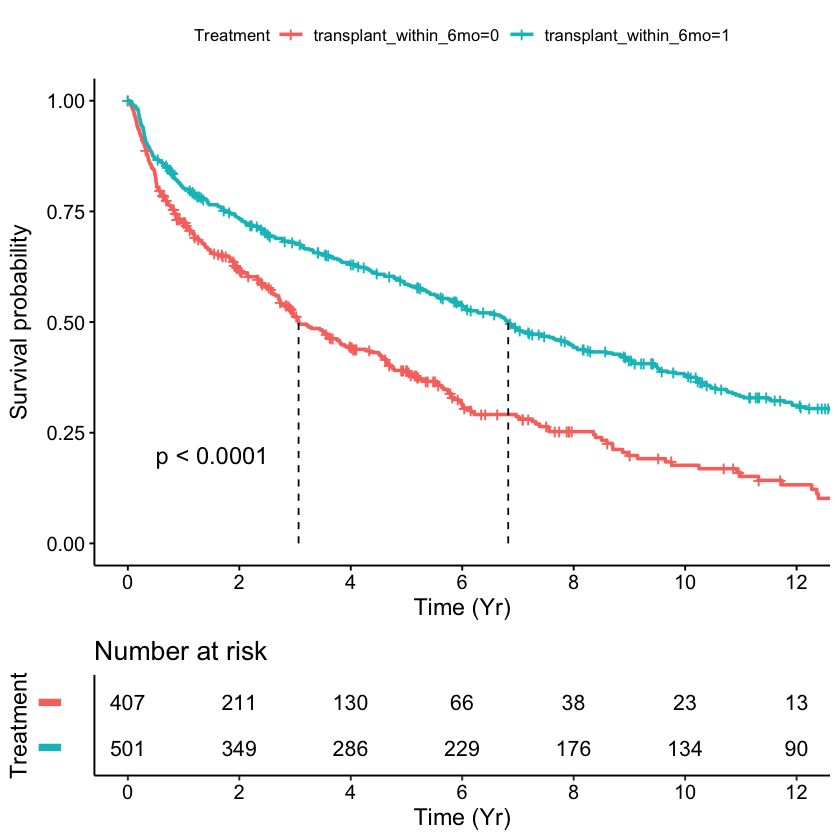

In [4]:
#pdf("figures/cluster_fna3_km_curve.pdf", h=8, w=6)
fit <- survfit(Surv(time_from_admission, status) ~ transplant_within_6mo, data=tx.df)
plotSurv(fit, tx.df, "Treatment", NULL, surv.median.line="v", xlim = c(0, 12), break.time.by=2)
dev.off()

null device 
          1

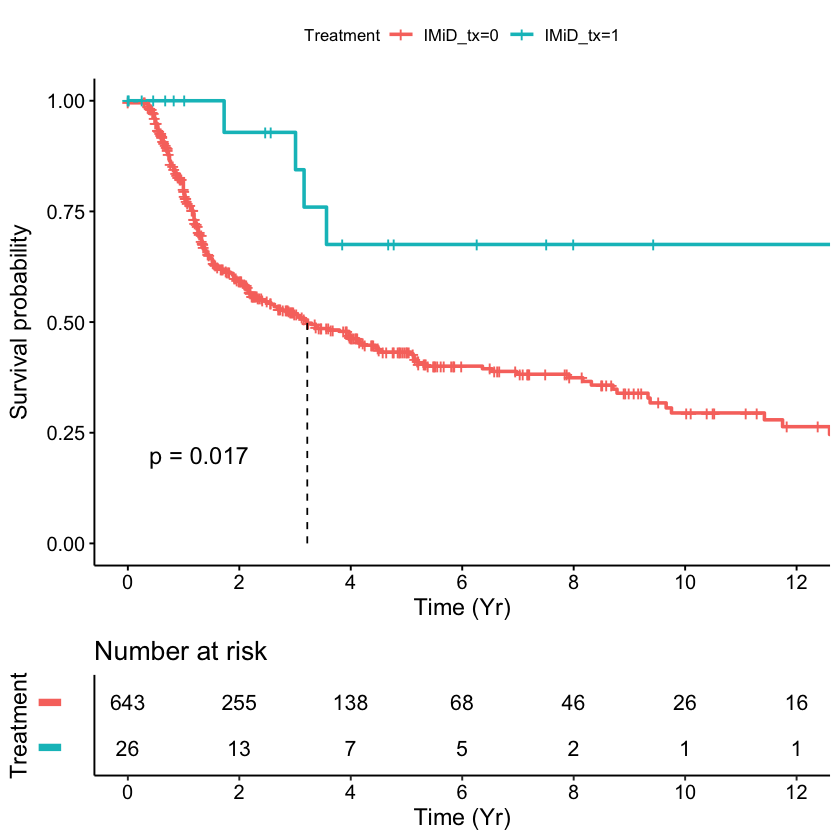

In [5]:
#pdf("figures/cluster_fna3_km_curve.pdf", h=8, w=6)
fit <- survfit(Surv(time_to_response, status_response) ~ IMiD_tx, data=tx.df)
plotSurv(fit, tx.df, "Treatment", NULL, surv.median.line="v", xlim = c(0, 12), break.time.by=2)
dev.off()

## 2a. Logistic Regression
---

In [24]:
mod <- glm(response_in_12mo ~ fna3_cluster_n + Age + Sex + Race+ strata(LC.Isotype) + strata(Era), data=tx.df, family=binomial(link="logit"))
summary(mod)


Call:
glm(formula = response_in_12mo ~ fna3_cluster_n + Age + Sex + 
    Race + strata(LC.Isotype) + strata(Era), family = binomial(link = "logit"), 
    data = tx.df)

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)   
(Intercept)                  0.321598   0.873940   0.368  0.71288   
fna3_cluster_nIntermediate   0.245134   0.224181   1.093  0.27419   
fna3_cluster_nHigh          -0.050052   0.335162  -0.149  0.88129   
Age                         -0.033664   0.010615  -3.171  0.00152 **
Sexmale                     -0.106348   0.210273  -0.506  0.61302   
RaceBlack                   -1.095424   0.793658  -1.380  0.16752   
RaceOther                  -14.737861 719.011414  -0.020  0.98365   
RaceWhite                   -0.178406   0.606618  -0.294  0.76868   
strata(LC.Isotype)L          0.006617   0.264937   0.025  0.98007   
strata(Era)Era_3             0.196044   0.289341   0.678  0.49805   
strata(Era)Era_4             0.520982   0.296043   1.760 

In [182]:
anova(mod, test='Chisq')

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,668,623.3257,NA
fna3_cluster_n,2,2.1227792,666,621.2030,0.3459747
PI_tx,1,0.4349085,665,620.7681,0.5095902
fna3_cluster_n:PI_tx,2,0.5534832,663,620.2146,0.7582504


## 2a. Time to Response
---

In [25]:
landmark.time <- 0.5

tx.landmark.df <- tx.df[tx.df$time_to_response>=landmark.time,]
tx.landmark.df <- tx.landmark.df %>%
    mutate(landmark_time = time_to_response - landmark.time)

In [26]:
response.crude <- coxph(Surv(time_to_relapse, status_relapse) ~ fna3_cluster_n + Age + Sex + Race+ strata(LC.Isotype) + strata(Era), 
    data=tx.landmark.df, x=TRUE)
df <- getCoef(response.crude)
df[order(df$exp.coef, decreasing=T),] 
df[df[5]<.1,]

ERROR: Error in eval(predvars, data, env): object 'time_to_relapse' not found


## 2. Cox Regression
---

In [207]:
# Baseline Model
mod <- coxph(Surv(time_from_admission, status) ~ transplant_within_6mo + Age + tt(Age) + Sex + Race + strata(LC.Isotype) + strata(Era), data=tx.df, x=TRUE, tt=function(x,t,...) x * log(t))
summary(mod)

Call:
coxph(formula = Surv(time_from_admission, status) ~ transplant_within_6mo + 
    Age + tt(Age) + Sex + Race + strata(LC.Isotype) + strata(Era), 
    data = tx.df, x = TRUE, tt = function(x, t, ...) x * log(t))

  n= 908, number of events= 621 

                           coef exp(coef)  se(coef)      z Pr(>|z|)    
transplant_within_6mo -0.663365  0.515115  0.097828 -6.781 1.19e-11 ***
Age                    0.009268  1.009311  0.004760  1.947 0.051545 .  
tt(Age)                0.011326  1.011390  0.002926  3.870 0.000109 ***
Sexmale                0.211053  1.234978  0.085550  2.467 0.013625 *  
RaceBlack              0.820769  2.272246  0.371390  2.210 0.027106 *  
RaceOther              1.239559  3.454089  0.609777  2.033 0.042072 *  
RaceWhite              0.375148  1.455206  0.340549  1.102 0.270637    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                      exp(coef) exp(-coef) lower .95 upper .95
transplant_within_6mo    0.5151     1.9413

In [14]:
# Baseline Model
mod <- coxph(Surv(time_from_admission, status) ~ fna3_cluster_n*tx_within_6mo + Age + tt(Age) + Sex + Race + strata(LC.Isotype) + strata(Era), data=tx.df, x=TRUE, tt=function(x,t,...) x * log(t))
summary(mod)

Call:
coxph(formula = Surv(time_from_admission, status) ~ fna3_cluster_n * 
    tx_within_6mo + Age + tt(Age) + Sex + Race + strata(LC.Isotype) + 
    strata(Era), data = tx.df, x = TRUE, tt = function(x, t, 
    ...) x * log(t))

  n= 908, number of events= 621 

                                                                        coef
fna3_cluster_nIntermediate                                          0.841543
fna3_cluster_nHigh                                                  1.284329
tx_within_6moHDM/SCT                                               -0.165429
tx_within_6moIMiD-based                                             0.498719
tx_within_6moMelphalan-based regimen                                0.437291
tx_within_6moProteasome inhibitor-based                             0.138807
Age                                                                 0.014082
tt(Age)                                                             0.012487
Sexmale                                   

In [42]:
# Baseline Model
mod <- coxph(Surv(time_from_admission, status) ~ fna3_cluster_n*IMiD_tx + Age + tt(Age) + Sex + Race + strata(LC.Isotype) + strata(Era), data=tx.df, x=TRUE, tt=function(x,t,...) x * log(t))
df <- getCoef(mod)
df <- df[order(df$HR, decreasing=T),]
df[df$Pr...z..<0.1,]

,coef,exp.coef.,se.coef.,z,Pr...z..,coef_exp,ci_lower,ci_upper,HR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
RaceOther,1.38475532,3.993849,0.607506522,2.279408,2.264281e-02,3.99,1.210,13.10,3.99 (1.21-13.1)
fna3_cluster_nHigh,0.95343898,2.594617,0.122142493,7.805956,5.905198e-15,2.59,2.040,3.30,2.59 (2.04-3.3)
RaceBlack,0.76469627,2.148342,0.371875924,2.056321,3.975159e-02,2.15,1.040,4.45,2.15 (1.04-4.45)
IMiD_tx,0.46773200,1.596370,0.266291674,1.756465,7.900905e-02,1.60,0.947,2.69,1.6 (0.947-2.69)
Sexmale,0.20654812,1.229427,0.086131115,2.398066,1.648188e-02,1.23,1.040,1.46,1.23 (1.04-1.46)
fna3_cluster_nIntermediate,0.20298995,1.225060,0.094018425,2.159044,3.084672e-02,1.23,1.020,1.47,1.23 (1.02-1.47)
Age,0.02413843,1.024432,0.004652497,5.188273,2.122527e-07,1.02,1.020,1.03,1.02 (1.02-1.03)
tt(Age),0.01340859,1.013499,0.003035943,4.416616,1.002580e-05,1.01,1.010,1.02,1.01 (1.01-1.02)


In [20]:
# Baseline Model
mod <- coxph(Surv(time_from_admission, status) ~ fna3_cluster_n*PI_tx + Age + tt(Age) + Sex + Race + strata(LC.Isotype) + strata(Era), data=tx.df, x=TRUE, tt=function(x,t,...) x * log(t))
df <- getCoef(mod)
df[order(df$HR, decreasing=T),]


,coef,exp.coef.,se.coef.,z,Pr...z..,coef_exp,ci_lower,ci_upper,HR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
RaceOther,1.44678282,4.249421,0.608983742,2.3757331,1.751413e-02,4.25,1.290,14.00,4.25 (1.29-14)
fna3_cluster_nHigh,0.91530805,2.497544,0.130271206,7.0261731,2.122751e-12,2.50,1.930,3.22,2.5 (1.93-3.22)
RaceBlack,0.78884342,2.200850,0.373006004,2.1148277,3.444464e-02,2.20,1.060,4.57,2.2 (1.06-4.57)
fna3_cluster_nIntermediate:PI_tx,0.56320505,1.756292,0.285214265,1.9746735,4.830521e-02,1.76,1.000,3.07,1.76 (1-3.07)
RaceWhite,0.35811801,1.430634,0.341959582,1.0472525,2.949832e-01,1.43,0.732,2.80,1.43 (0.732-2.8)
Sexmale,0.20299246,1.225063,0.085963410,2.3613821,1.820696e-02,1.23,1.040,1.45,1.23 (1.04-1.45)
fna3_cluster_nIntermediate,0.13007078,1.138909,0.097242809,1.3375877,1.810309e-01,1.14,0.941,1.38,1.14 (0.941-1.38)
fna3_cluster_nHigh:PI_tx,0.11941853,1.126841,0.321635057,0.3712858,7.104247e-01,1.13,0.600,2.12,1.13 (0.6-2.12)
PI_tx,0.02610331,1.026447,0.224779583,0.1161285,9.075507e-01,1.03,0.661,1.59,1.03 (0.661-1.59)


In [24]:
# Baseline Model
mod <- coxph(Surv(time_from_admission, status) ~ fna3_cluster_n + Age + tt(Age) + Sex + Race + strata(LC.Isotype) + strata(Era), data=tx.df, x=TRUE, tt=function(x,t,...) x * log(t))
summary(mod)

Call:
coxph(formula = Surv(time_from_admission, status) ~ fna3_cluster_n + 
    tx_within_6mo + Age + tt(Age) + Sex + Race + strata(LC.Isotype) + 
    strata(Era), data = tx.df, x = TRUE, tt = function(x, t, 
    ...) x * log(t))

  n= 908, number of events= 621 

                                             coef exp(coef)  se(coef)      z
fna3_cluster_nIntermediate               0.202897  1.224946  0.091821  2.210
fna3_cluster_nHigh                       0.837913  2.311539  0.121094  6.920
tx_within_6moHDM/SCT                    -0.546904  0.578739  0.255378 -2.142
tx_within_6moIMiD-based                  0.100139  1.105325  0.301687  0.332
tx_within_6moMelphalan-based regimen     0.036116  1.036776  0.267653  0.135
tx_within_6moProteasome inhibitor-based -0.013249  0.986839  0.238694 -0.056
Age                                      0.013857  1.013954  0.004905  2.825
tt(Age)                                  0.012345  1.012422  0.002964  4.165
Sexmale                                  0

In [189]:
# Baseline Model
mod <- coxph(Surv(time_from_admission, status) ~ fna3_cluster_n*PI_tx + Age + tt(Age) + Sex + Race + strata(LC.Isotype) + strata(Era), data=tx.df, x=TRUE, tt=function(x,t,...) x * log(t))
summary(mod)

Call:
coxph(formula = Surv(time_from_admission, status) ~ fna3_cluster_n * 
    PI_tx + Age + tt(Age) + Sex + Race + strata(LC.Isotype) + 
    strata(Era), data = tx.df, x = TRUE, tt = function(x, t, 
    ...) x * log(t))

  n= 908, number of events= 621 

                                     coef exp(coef) se(coef)     z Pr(>|z|)    
fna3_cluster_nIntermediate       0.130071  1.138909 0.097243 1.338   0.1810    
fna3_cluster_nHigh               0.915308  2.497544 0.130271 7.026 2.12e-12 ***
PI_tx                            0.026103  1.026447 0.224780 0.116   0.9076    
Age                              0.023404  1.023680 0.004665 5.017 5.25e-07 ***
tt(Age)                          0.013431  1.013522 0.003042 4.416 1.01e-05 ***
Sexmale                          0.202992  1.225063 0.085963 2.361   0.0182 *  
RaceBlack                        0.788843  2.200850 0.373006 2.115   0.0344 *  
RaceOther                        1.446783  4.249421 0.608984 2.376   0.0175 *  
RaceWhite              

In [115]:
# Baseline Model
tx.crude <- coxph(Surv(time_from_admission, status) ~ fna3_cluster_n, data=tx.df, x=TRUE)
tx.baseline <- coxph(Surv(time_from_admission, status) ~ fna3_cluster_n + Age + Sex + Race + strata(LC.Isotype) + strata(Era), data=tx.df, x=TRUE)
tx.baseline.t <- coxph(Surv(time_from_admission, status) ~ fna3_cluster_n + Age + tt(Age) + Sex + Race + strata(LC.Isotype) + strata(Era), data=tx.df, x=TRUE, tt=function(x,t,...) x * log(t))
cox.zph((tx.baseline))

                chisq df       p
fna3_cluster_n 18.847  2 8.1e-05
Age            17.243  1 3.3e-05
Sex             0.190  1    0.66
Race            0.721  3    0.87
GLOBAL         30.128  7 9.0e-05

In [116]:
tx.baseline.tx.t <- coxph(Surv(time_from_admission, status) ~ fna3_cluster_n + tx_within_6mo + 
    Age + tt(Age) + Sex + Race + strata(LC.Isotype) + strata(Era), data=tx.df, x=TRUE, tt=function(x,t,...) x * log(t))

summary(tx.baseline.t)

Call:
coxph(formula = Surv(time_from_admission, status) ~ fna3_cluster_n + 
    Age + tt(Age) + Sex + Race + strata(LC.Isotype) + strata(Era), 
    data = tx.df, x = TRUE, tt = function(x, t, ...) x * log(t))

  n= 908, number of events= 621 

                               coef exp(coef) se(coef)     z Pr(>|z|)    
fna3_cluster_nIntermediate 0.189846  1.209064 0.091523 2.074   0.0381 *  
fna3_cluster_nHigh         0.928290  2.530179 0.119397 7.775 7.55e-15 ***
Age                        0.024392  1.024692 0.004639 5.258 1.45e-07 ***
tt(Age)                    0.013352  1.013441 0.003042 4.390 1.14e-05 ***
Sexmale                    0.204695  1.227151 0.085801 2.386   0.0170 *  
RaceBlack                  0.781891  2.185600 0.371700 2.104   0.0354 *  
RaceOther                  1.378091  3.967320 0.607445 2.269   0.0233 *  
RaceWhite                  0.347758  1.415889 0.341419 1.019   0.3084    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                      

In [120]:
tx.interaction.tx.t <- coxph(Surv(time_from_admission, status) ~ fna3_cluster_n * tx_within_6mo, data=tx.df, 
    x=TRUE, tt=function(x,t,...) x * log(t))
summary(tx.interaction.tx.t)

Call:
coxph(formula = Surv(time_from_admission, status) ~ fna3_cluster_n * 
    tx_within_6mo, data = tx.df, x = TRUE, tt = function(x, t, 
    ...) x * log(t))

  n= 908, number of events= 621 

                                                                      coef
fna3_cluster_nIntermediate                                          0.8586
fna3_cluster_nHigh                                                  1.2480
tx_within_6moHDM/SCT                                                0.4004
tx_within_6moIMiD-based                                             0.8552
tx_within_6moMelphalan-based regimen                                1.2354
tx_within_6moProteasome inhibitor-based                             0.3101
fna3_cluster_nIntermediate:tx_within_6moHDM/SCT                    -0.7216
fna3_cluster_nHigh:tx_within_6moHDM/SCT                            -0.7866
fna3_cluster_nIntermediate:tx_within_6moIMiD-based                 -0.5808
fna3_cluster_nHigh:tx_within_6moIMiD-based            

In [118]:
tx.interaction.tx.t <- coxph(Surv(time_from_admission, status) ~ fna3_cluster_n * tx_within_6mo + 
    Age + tt(Age) + Sex + Race + strata(LC.Isotype) + strata(Era), data=tx.df, x=TRUE, tt=function(x,t,...) x * log(t))

summary(tx.interaction.tx.t)

Call:
coxph(formula = Surv(time_from_admission, status) ~ fna3_cluster_n * 
    tx_within_6mo + Age + tt(Age) + Sex + Race + strata(LC.Isotype) + 
    strata(Era), data = tx.df, x = TRUE, tt = function(x, t, 
    ...) x * log(t))

  n= 908, number of events= 621 

                                                                        coef
fna3_cluster_nIntermediate                                          0.841543
fna3_cluster_nHigh                                                  1.284329
tx_within_6moHDM/SCT                                               -0.165429
tx_within_6moIMiD-based                                             0.498719
tx_within_6moMelphalan-based regimen                                0.437291
tx_within_6moProteasome inhibitor-based                             0.138807
Age                                                                 0.014082
tt(Age)                                                             0.012487
Sexmale                                   

In [119]:
df <- getCoef(tx.interaction.tx.t)
df[df$exp.coef. > 1,]

,coef,exp.coef.,se.coef.,z,Pr...z..,coef_exp,ci_lower,ci_upper,HR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
fna3_cluster_nIntermediate,0.84154251,2.319943,0.546344070,1.5403160,1.234833e-01,2.32,0.795,6.77,2.32 (0.795-6.77)
fna3_cluster_nHigh,1.28432881,3.612243,0.504656530,2.5449563,1.092914e-02,3.61,1.340,9.71,3.61 (1.34-9.71)
tx_within_6moIMiD-based,0.49871873,1.646610,0.498482193,1.0004745,3.170809e-01,1.65,0.620,4.37,1.65 (0.62-4.37)
tx_within_6moMelphalan-based regimen,0.43729088,1.548506,0.464846062,0.9407219,3.468474e-01,1.55,0.623,3.85,1.55 (0.623-3.85)
tx_within_6moProteasome inhibitor-based,0.13880691,1.148902,0.464641406,0.2987399,7.651385e-01,1.15,0.462,2.86,1.15 (0.462-2.86)
Age,0.01408227,1.014182,0.004964957,2.8363327,4.563488e-03,1.01,1.000,1.02,1.01 (1-1.02)
tt(Age),0.01248653,1.012565,0.002988143,4.1786913,2.931913e-05,1.01,1.010,1.02,1.01 (1.01-1.02)
Sexmale,0.19795852,1.218912,0.086239379,2.2954540,2.170712e-02,1.22,1.030,1.44,1.22 (1.03-1.44)
RaceBlack,0.72114281,2.056782,0.374351442,1.9263792,5.405705e-02,2.06,0.987,4.28,2.06 (0.987-4.28)
